In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import networkx as nx

df = pd.read_csv(r"C:\Users\USER\Downloads\25_june_isrc_final.csv")
df.head(5)



,ISRC,Chartmetric ID,Track Name,Artists,Tags,Genres,Genre IDs,Moods,Activities
0,INZ031415512,134320626.0,"Dobara Humein Kya - From ""Auron Mein Kahan Dum...","M. M. Kreem, Jubin Nautiyal, Sunidhi Chauhan",bollywood,bollywood,501219,"ROMANTIC, DARK",NaN
1,INS181303031,17063542.0,Tum Hi Ho,"Mithoon, Arijit Singh","bollywood, pakistani fusion, south asian class...","bollywood, south asian classical, indian fusio...","501219, 503287, 507684, 507743, 507755","affectionate, emotional, dramatic, heartwarmin...","sleep, soft, lofi, study"
2,INS182402832,137371544.0,"Raanjhan (From ""Do Patti"")","Parampara Tandon, Sachet-Parampara, Kausar Munir","bollywood, new romantic, pakistani fusion, sou...","bollywood, south asian classical, new romantic...","501219, 503287, 507743, 507755","betrayal, longing, melancholic, wistful","soft, lofi"
3,INH102500536,142519267.0,"Tu Hain Toh Main Hoon (From ""Sky Force"")","Tanishk Bagchi, Arijit Singh, Afsana Khan, Irs...","bollywood, haryanvi, punjabi, new romantic","bollywood, haryanvi, punjabi, new romantic","501219, 501514, 501717, 507743","affectionate, devoted, uplifting, heartwarming...","soft, sleep"
4,INH102409256,131161883.0,"Aaj Ki Raat (From ""Stree 2"")","Sachin-Jigar, Madhubanti Bagchi, Divya Kumar, ...","indian fusion, new romantic, indian pop, bolly...","bollywood, indian pop, south asian classical, ...","501219, 501220, 503287, 507684, 507743, 507755","chill, happy, soulful, fun, family, energetic","late-night, self-love"


Enter a song name (partial ok):  Dobara Humein Kya



Choose similarity mode:
1. All tags (Genres + Moods + Activities)
2. Genres only
3. Moods only
4. Activities only


Enter 1/2/3/4:  1



SONG SIMILARITY ANALYSIS FOR: Dobara Humein Kya - From "Auron Mein Kahan Dum Tha" - M. M. Kreem, Jubin Nautiyal, Sunidhi Chauhan

Top 10 Songs Most Similar to 'Dobara Humein Kya - From "Auron Mein Kahan Dum Tha" - M. M. Kreem, Jubin Nautiyal, Sunidhi Chauhan':
Rank  Song                                          Similarity   Distance  
--------------------------------------------------------------------------------
1     Jahan Se Chale The - From "Auron Mein Kahan Dum Tha" - Jubin Nautiyal, Sunidhi Chauhan, M. M. Kreem, Manoj Muntashir 1.0000       0.0000    
2     Maine Khud Ko (Reprise) - Kshitij Tarey, Sunny Leone, Natassha, Pravin Dabas, Sandhya Mridul 0.8539       0.1461    
3     Zor Ki Barsaat Hui - Jubin Nautiyal, Rochak Kohli, Gurpreet Saini 0.8226       0.1774    
4     Dil Ne Dil Ko Pukara - Babul Supriyo, Chorus  0.8226       0.1774    
5     Khoobsurat - LoFi Mix - DJ Aftab, Vishal Mishra, Sachin-Jigar 0.8187       0.1813    
6     Man Kyoon Behka Re Behka Aadhi Raat Ko - 

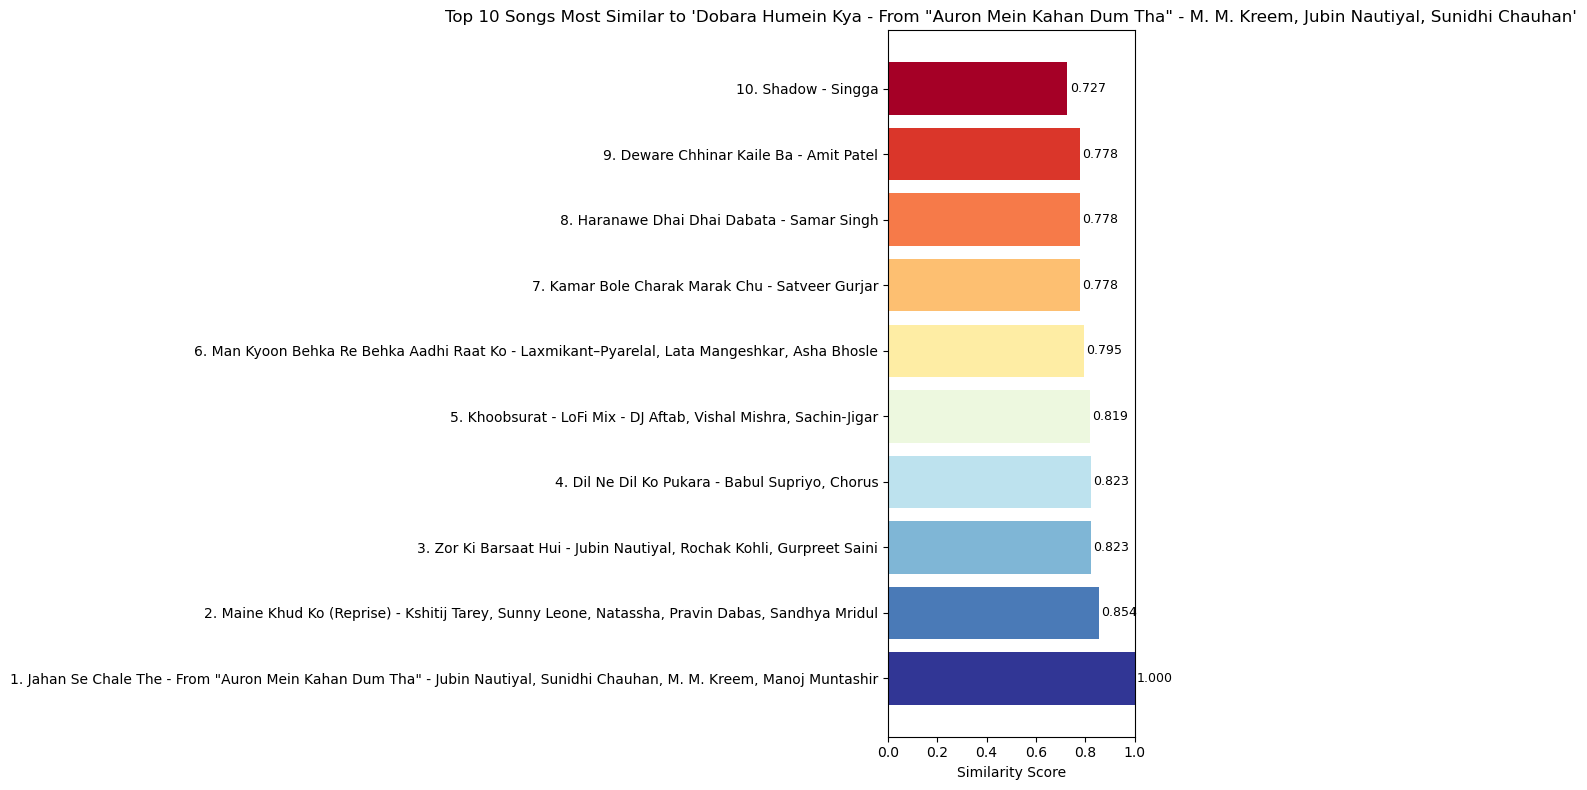

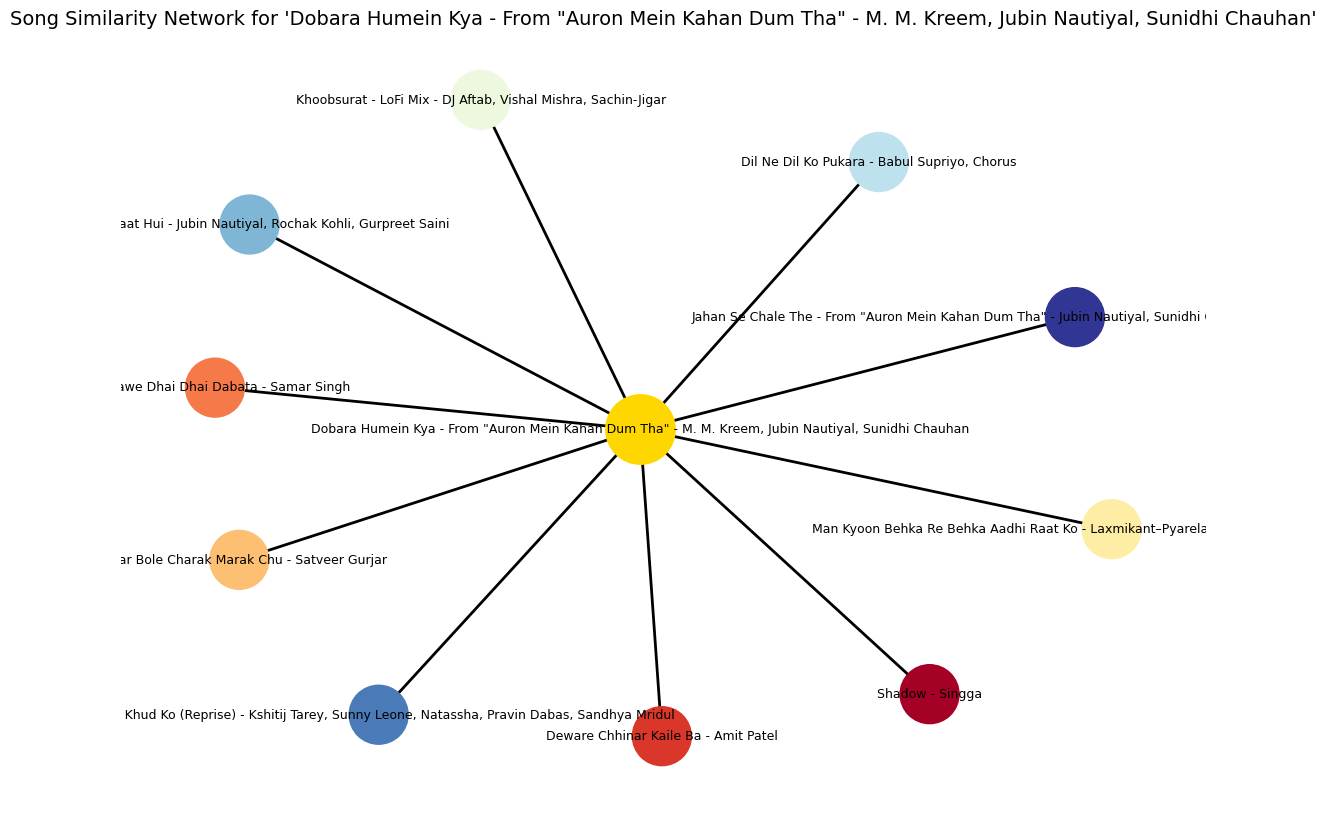

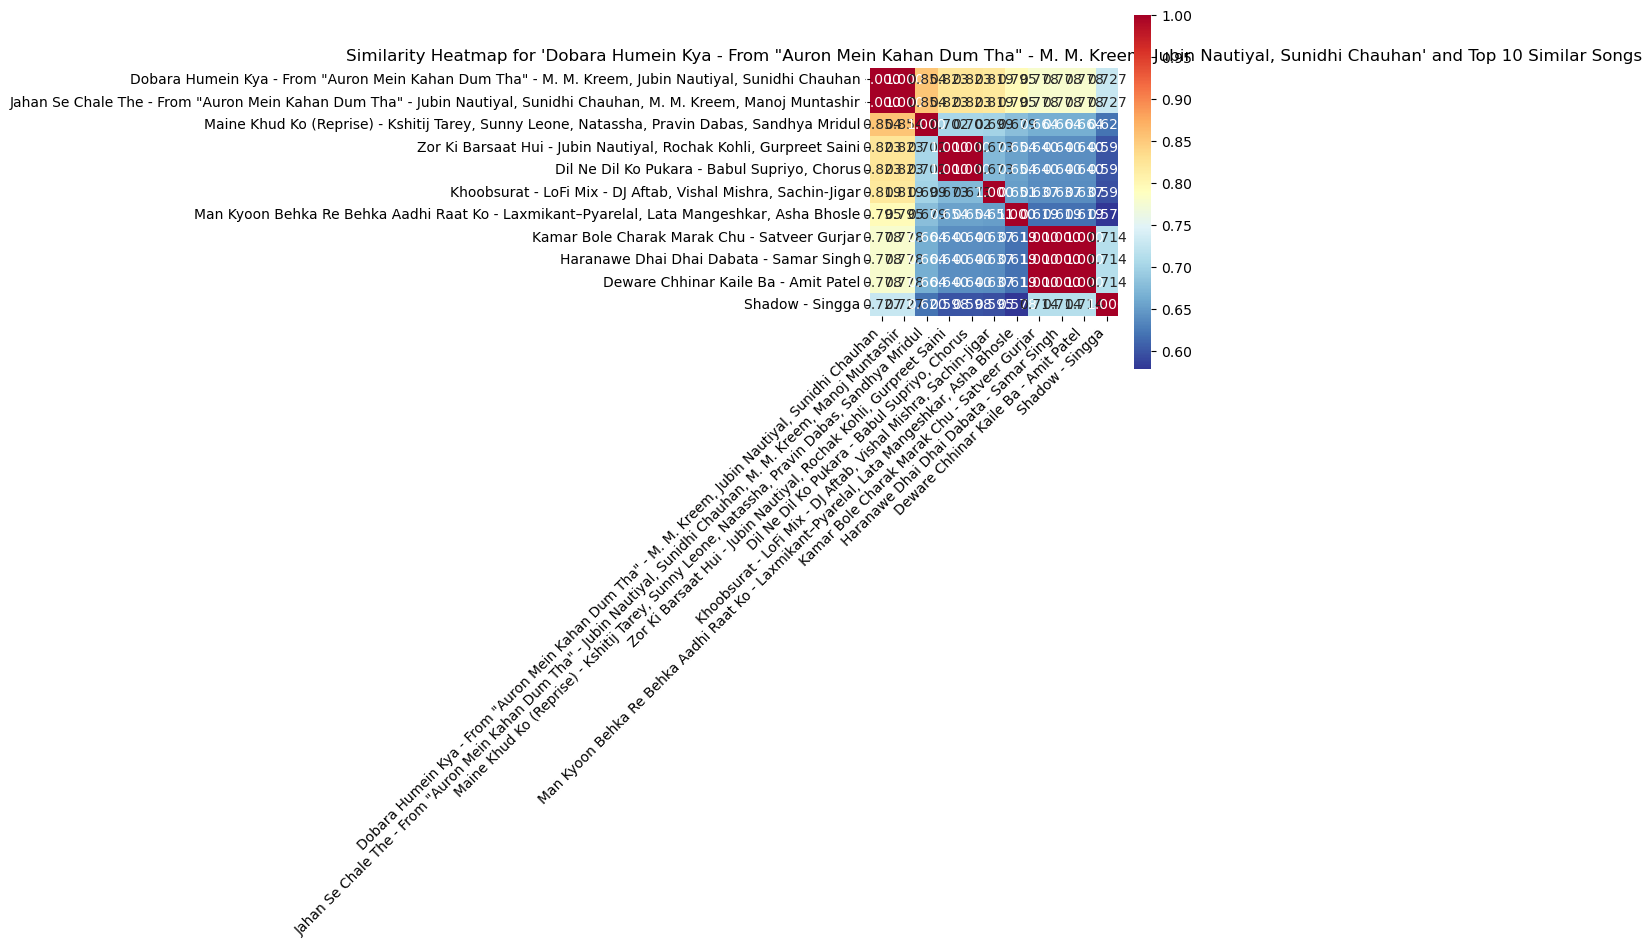


✅ All visualizations saved as PNG files!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import networkx as nx
import re

# Load data
df = pd.read_csv(r"C:\Users\USER\Downloads\25_june_isrc_final.csv")

# check required columns
required = ['Track Name', 'Artists', 'Genres', 'Moods', 'Activities']
for col in required:
    if col not in df.columns:
        raise ValueError(f"Missing column: {col}")

# build a unique song ID as "Track Name - Artist"
df['SongID'] = df['Track Name'].astype(str) + " - " + df['Artists'].astype(str)

# helper for safe filenames
def safe_filename(name):
    return re.sub(r'[<>:"/\\|?*]', "_", name)

# function to let user pick a song with partial match
def choose_song_by_partial(song_input):
    matches = df[df['Track Name'].str.contains(song_input, case=False, na=False)]
    if matches.empty:
        return None, f"No songs found matching '{song_input}'."
    elif len(matches) == 1:
        return matches.iloc[0], None
    else:
        print("\nMultiple matches found:")
        for idx, row in matches.iterrows():
            print(f"{idx}: {row['Track Name']} by {row['Artists']}")
        while True:
            try:
                choice = int(input("Enter the index of the song you want to pick: "))
                if choice in matches.index:
                    return matches.loc[choice], None
                else:
                    print("Invalid index, try again.")
            except ValueError:
                print("Please enter a valid number.")

# ask similarity mode
def ask_similarity_mode():
    print("\nChoose similarity mode:")
    print("1. All tags (Genres + Moods + Activities)")
    print("2. Genres only")
    print("3. Moods only")
    print("4. Activities only")
    while True:
        choice = input("Enter 1/2/3/4: ").strip()
        if choice in {"1", "2", "3", "4"}:
            return int(choice)
        print("Invalid choice, try again.")

# recompute similarity matrix based on choice
def build_similarity_matrix(mode):
    if mode == 1:
        features = (
            df['Genres'].fillna('') + ", "
            + df['Moods'].fillna('') + ", "
            + df['Activities'].fillna('')
        )
    elif mode == 2:
        features = df['Genres'].fillna('')
    elif mode == 3:
        features = df['Moods'].fillna('')
    else:
        features = df['Activities'].fillna('')
    
    vectorizer = TfidfVectorizer(stop_words="english")
    tag_vectors = vectorizer.fit_transform(features)
    return cosine_similarity(tag_vectors)

def get_similar_songs(song_idx, similarity_matrix, top_n=10):
    similarities = similarity_matrix[song_idx]
    similar_indices = np.argsort(-similarities)
    similar_data = []
    for idx in similar_indices:
        if idx == song_idx:
            continue
        if len(similar_data) >= top_n:
            break
        similar_data.append({
            'rank': len(similar_data)+1,
            'song': df.loc[idx, 'SongID'],
            'similarity': similarities[idx],
            'distance': 1 - similarities[idx]
        })
    return similar_data

# plots
def plot_similarity_ranking(song_id, similar_songs):
    similarities = [s['similarity'] for s in similar_songs]
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(similarities)))
    fig, ax = plt.subplots(figsize=(12, 8))
    songs = [s['song'] for s in similar_songs]
    bars = ax.barh(range(len(songs)), similarities, color=colors)
    ax.set_yticks(range(len(songs)))
    ax.set_yticklabels([f"{i+1}. {s}" for i, s in enumerate(songs)])
    ax.set_xlabel('Similarity Score')
    ax.set_title(f"Top 10 Songs Most Similar to '{song_id}'")
    ax.set_xlim(0, 1)
    for i, (bar, score) in enumerate(zip(bars, similarities)):
        ax.text(score + 0.01, i, f"{score:.3f}", va="center", fontsize=9)
    plt.tight_layout()
    plt.savefig(f'similarity_ranking_{safe_filename(song_id)}.png', dpi=300)
    plt.show()

def plot_similarity_network(song_id, similar_songs):
    G = nx.Graph()
    G.add_node(song_id)
    for s in similar_songs:
        G.add_node(s['song'])
        G.add_edge(song_id, s['song'], weight=s['similarity'])
    pos = nx.spring_layout(G, seed=42, k=1.5)
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, nodelist=[song_id], node_color='gold', node_size=2500)
    similar_names = [s['song'] for s in similar_songs]
    colors = plt.cm.RdYlBu_r(np.linspace(0, 1, len(similar_names)))
    nx.draw_networkx_nodes(G, pos, nodelist=similar_names, node_color=colors, node_size=1800)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.title(f"Song Similarity Network for '{song_id}'", fontsize=14)
    plt.axis("off")
    plt.savefig(f'similarity_network_{safe_filename(song_id)}.png', dpi=300)
    plt.show()

def plot_similarity_heatmap(song_id, similar_songs, similarity_matrix):
    song_names = [song_id] + [s['song'] for s in similar_songs]
    indices = [df[df['SongID'] == name].index[0] for name in song_names]
    sub_matrix = similarity_matrix[np.ix_(indices, indices)]
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        sub_matrix,
        xticklabels=song_names,
        yticklabels=song_names,
        annot=True,
        fmt=".3f",
        cmap="RdYlBu_r",
        square=True
    )
    plt.title(f"Similarity Heatmap for '{song_id}' and Top 10 Similar Songs")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f'similarity_heatmap_{safe_filename(song_id)}.png', dpi=300)
    plt.show()

# === MAIN DRIVER ===
song_input = input("Enter a song name (partial ok): ").strip()
chosen_song, error = choose_song_by_partial(song_input)

if error:
    print(error)
else:
    mode = ask_similarity_mode()
    similarity_matrix = build_similarity_matrix(mode)
    song_idx = chosen_song.name
    similar_songs = get_similar_songs(song_idx, similarity_matrix, top_n=10)
    song_id = chosen_song['SongID']
    
    print(f"\n{'='*60}")
    print(f"SONG SIMILARITY ANALYSIS FOR: {song_id}")
    print(f"{'='*60}")
    print(f"\nTop 10 Songs Most Similar to '{song_id}':")
    print(f"{'Rank':<5} {'Song':<45} {'Similarity':<12} {'Distance':<10}")
    print("-" * 80)
    for s in similar_songs:
        print(f"{s['rank']:<5} {s['song']:<45} {s['similarity']:<12.4f} {s['distance']:<10.4f}")
    
    print(f"\n{'='*60}")
    print("GENERATING VISUALIZATIONS...")
    print(f"{'='*60}")
    
    plot_similarity_ranking(song_id, similar_songs)
    plot_similarity_network(song_id, similar_songs)
    plot_similarity_heatmap(song_id, similar_songs, similarity_matrix)
    
    print(f"\n✅ All visualizations saved as PNG files!")
